# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Hanif | Bhuian | Hanif Bhuian, Nov 8, 2024 | 5 | 25% |
| Member 2: | Tanvir | Tusher | Tanvir Hassan Tusher, 07 Nov 2024 | 5 | 25% |
| Member 3: | Janvi | Desai | janvi Desai, 7 Nov 2024  | 5 | 25% |
| Member 4: | Tanzina | Khan | Tanzina Khan, 7 Nov 2024 | 5 | 25% |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

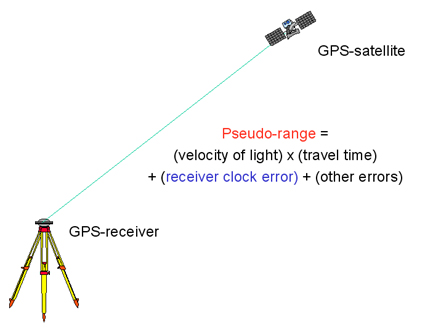

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [45]:
df_pseudorange = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ENGG680_Fall24_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/ENGG680_Fall24_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [46]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [47]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [48]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [49]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric distance using euclidean_norm
    predicted_pseudorange = euclidean_norm(r_pos, s_pos) + cdT

    # Compute the residuals
    residuals = pseudorange - predicted_pseudorange

    # Sum of squared residuals
    L = np.sum(residuals**2)

    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [50]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    # Calculate the geometric distances
    distances = euclidean_norm(r_pos, s_pos)

    # Predicted pseudoranges with clock offset
    predicted_pseudorange = distances + cdT

    # Compute residuals
    residuals = pseudorange - predicted_pseudorange

    # Calculate partial derivatives with respect to x_r, y_r, and z_r
    # Directional derivatives for each coordinate
    dL_dx = -np.sum(residuals * (r_pos[0] - s_pos[:, 0]) / distances)
    dL_dy = -np.sum(residuals * (r_pos[1] - s_pos[:, 1]) / distances)
    dL_dz = -np.sum(residuals * (r_pos[2] - s_pos[:, 2]) / distances)

    # Partial derivative with respect to clock offset (cdT)
    dL_dcdT = -np.sum(residuals)

    # Return the gradient as a numpy array
    grad = np.array([dL_dx, dL_dy, dL_dz, dL_dcdT])

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [51]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.01, max_iters=100000, tolerance=1e-6):

    global steps_count

    # Initialize the estimates as zeros
    X = np.array([0.0, 0.0, 0.0, 0.0])

    for iteration in range(max_iters):
        # Separate the receiver position and clock offset from X
        r_pos = X[:3]
        cdT = X[3]

        # Compute the cost in the current step
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # Compute the gradients in the current step
        grad = gradient(r_pos, cdT, s_pos, pseudorange)

        # Update estimates
        X_new = X - learning_rate * grad

        # Compute the new cost
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # Check for convergence
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged!")
            steps_count = iteration
            break

        # Update the parameters for the next iteration
        X = X_new

        # Collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3] - GroundTruth)

    return X


### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [52]:
# Call gradient_descent function to optimize the estimating parameters using default optimization hyperparameters
optimized_params = gradient_descent(pseudorange, sat_pos)

# Calculate the final position error of the receiver
final_position_error = optimized_params[:3] - GroundTruth

# Print the required metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)
print("Final Position Errors of Receiver:", final_position_error)
print("Number of Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1])
print("Final Gradient Values:", arr_grad[-1])


Converged!
Optimized Parameters (x_r, y_r, z_r, cdT): [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46239527e+00]
Final Position Errors of Receiver: [-3.06384888 -2.3543555   3.79619298]
Number of Steps Taken for Convergence: 5652
Final Cost Value: 6.197166705529241
Final Gradient Values: [ 0.00034695  0.00193321 -0.00594157 -0.00336846]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

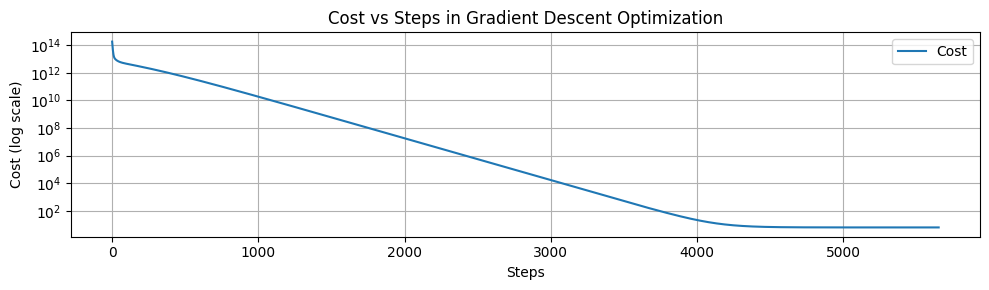

In [53]:
# fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# # ...
# ax.grid(True)
# fig.tight_layout()
# plt.show()

# # Comment on the pattern
# # ...

# Plot cost vs steps with semilogy scaling on y-axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Plot the cost values
ax.semilogy(arr_cost, label="Cost")

# Label the axes and add a title
ax.set_xlabel("Steps")
ax.set_ylabel("Cost (log scale)")
ax.set_title("Cost vs Steps in Gradient Descent Optimization")
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()


### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

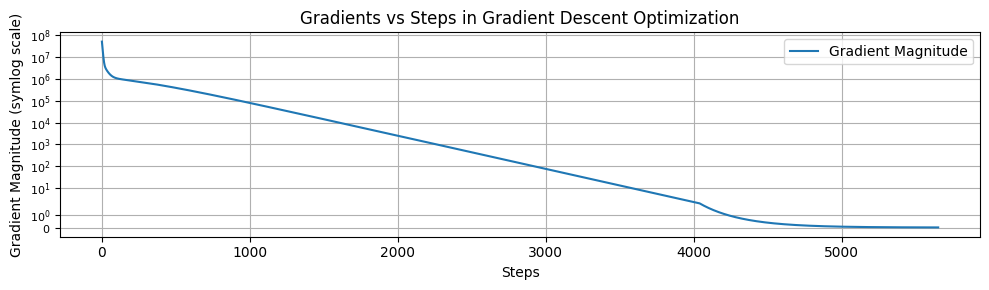

In [54]:
# fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# # ...
# ax.grid(True)
# fig.tight_layout()
# plt.show()

# # Comment on the pattern
# # ...

# Plot gradients vs steps with symlog scaling on y-axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Calculate the magnitude of each gradient for plotting
gradient_magnitudes = [np.linalg.norm(g) for g in arr_grad]

# Plot the gradient magnitudes
ax.plot(gradient_magnitudes, label="Gradient Magnitude")
ax.set_yscale("symlog")  # Use symmetric log scale for y-axis

# Label the axes and add a title
ax.set_xlabel("Steps")
ax.set_ylabel("Gradient Magnitude (symlog scale)")
ax.set_title("Gradients vs Steps in Gradient Descent Optimization")
ax.tick_params(axis="y", labelsize=8)
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

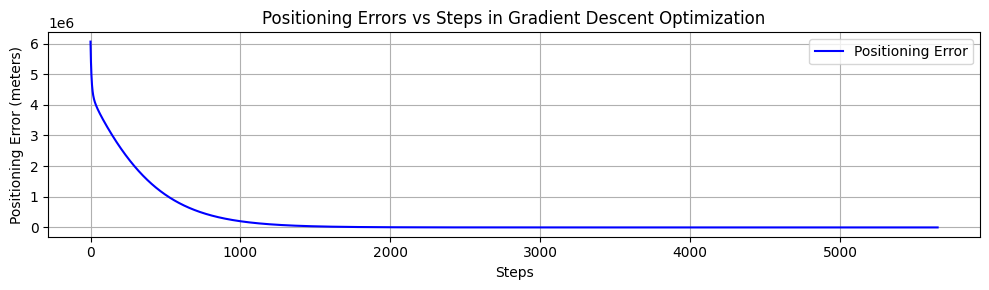

In [55]:
# Plot positioning errors vs steps
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Extract positioning errors from arr_err
positioning_errors = [np.linalg.norm(error) for error in arr_err]

# Plot positioning errors
ax.plot(positioning_errors, label="Positioning Error", color="blue")

# Label the axes and add a title
ax.set_xlabel("Steps")
ax.set_ylabel("Positioning Error (meters)")
ax.set_title("Positioning Errors vs Steps in Gradient Descent Optimization")
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [56]:

# Set learning rate to 0.01
learning_rate_2 = 0.01
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Run gradient descent with learning rate = 0.01
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_2, max_iters=200000, tolerance=1e-6)

# Print the metrics for learning rate 0.01
print("Learning Rate: 0.01")
print("Optimized Parameters:", optimized_params_2)
print("Final Position Errors:", optimized_params_2[:3] - GroundTruth)
print("Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1] if arr_cost else None)
print("Final Gradient Values:", arr_grad[-1] if arr_grad else None)




Converged!
Learning Rate: 0.01
Optimized Parameters: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46239527e+00]
Final Position Errors: [-3.06384888 -2.3543555   3.79619298]
Steps Taken for Convergence: 5652
Final Cost Value: 6.197166705529241
Final Gradient Values: [ 0.00034695  0.00193321 -0.00594157 -0.00336846]


In [57]:
# Set learning rate to 0.001
learning_rate_3 = 0.001
arr_cost = []
arr_grad = []
arr_err = []
steps_count = 0

# Run gradient descent with learning rate = 0.001
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_3, max_iters=500000, tolerance=1e-6)

# Print the metrics for learning rate 0.001
print("\nLearning Rate: 0.001")
print("Optimized Parameters:", optimized_params_3)
print("Final Position Errors:", optimized_params_3[:3] - GroundTruth)
print("Steps Taken for Convergence:", steps_count)
print("Final Cost Value:", arr_cost[-1] if arr_cost else None)
print("Final Gradient Values:", arr_grad[-1] if arr_grad else None)

Converged!

Learning Rate: 0.001
Optimized Parameters: [-1.63349244e+06 -3.65162952e+06  4.95248538e+06  6.44140645e+00]
Final Position Errors: [-3.06168702 -2.34230964  3.759171  ]
Steps Taken for Convergence: 53291
Final Cost Value: 6.198478264052894
Final Gradient Values: [ 0.00110058  0.00613234 -0.01884729 -0.01068509]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

---
---

## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)



ANSWER HERE

**Q1 Answer:** The main difference observed is in the number of steps required for convergence. With a learning rate of 0.01, the algorithm converged in 5,652 steps, whereas with a learning rate of 0.001, it took 53,291 steps. This indicates that the smaller learning rate (0.001) resulted in slower progress, requiring more iterations to reach a similar solution. Both learning rates achieved comparable accuracy in terms of final position errors and cost values, but the higher learning rate (0.01) was more efficient in terms of steps.


**Q2 Answer:** Least Squares Estimation (LSE) is an optimization technique that minimizes the sum of squared residuals to find the best-fit parameters. In LSE, the solution can often be found directly by solving normal equations (if they exist and are computationally feasible). In contrast, Gradient Descent is an iterative optimization method that gradually adjusts parameters in the direction that reduces the cost function. In the context of this task, Gradient Descent allows us to converge on an optimal solution through multiple steps, with the convergence speed and accuracy influenced by the learning rate.

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [59]:
!pip install ucimlrepo

In [60]:
from ucimlrepo import fetch_ucirepo

# # Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# Access the data and target directly from the fetched object
X = phishing_websites.data.features
y = phishing_websites.data.targets

# # TO DO: data (as pandas dataframes) (1 mark)
df = pd.concat([X, y], axis=1) #dataframes creation
df['result'] = df['result'].astype(int)  #target column encoded

# Separate features and target
X = df.drop(columns='result')
y = df['result']

# # TO DO: display sizes of X and y (1 mark)
print("Size of X:", X.shape)
print("Size of y:", y.shape)

Size of X: (11055, 30)
Size of y: (11055,)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

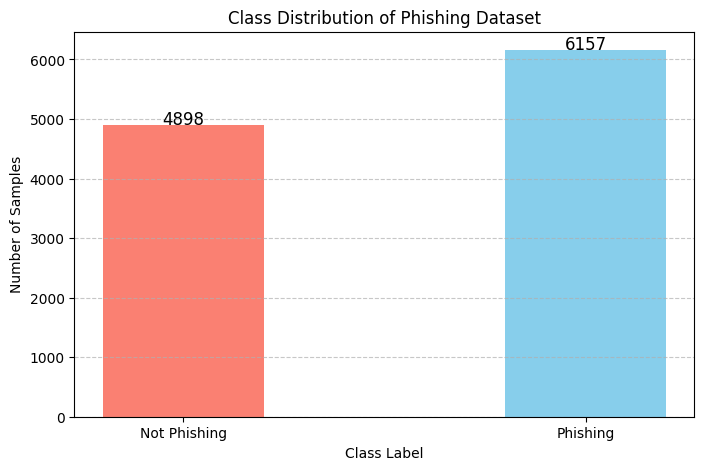

In [61]:
# TO DO: Check the class distribution of y (2 mark)
plt.figure(figsize=(8, 5))
class_counts = y.value_counts()
plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])


# Display exact values for each bin in the histogram
for index, value in enumerate(class_counts.values):
    plt.text(class_counts.index[index], value + 10, str(value), ha='center', fontsize=12)


# Set labels and title
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution of Phishing Dataset")
plt.xticks(ticks=[-1, 1], labels=["Not Phishing", "Phishing"])  # Assuming -1 and 1 are the class labels

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [62]:
from sklearn.model_selection import train_test_split
# TO DO: Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42, stratify=y)


# TO DO: display sizes of X_small and y_small (2 mark)
print("Size of X_small:", X_small.shape)
print("Size of y_small:", y_small.shape)

Size of X_small: (331, 30)
Size of y_small: (331,)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 3: Implement Machine Learning Model
model_full = LogisticRegression(max_iter=2000)

# 1. Using the full dataset (X and y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_full.fit(X_train, y_train)
y_pred = model_full.predict(X_test)
accuracy_full = accuracy_score(y_test, y_pred)
print(f'Accuracy with full dataset: {accuracy_full:.2f}')

# 2. Using only the first two columns of X and y
X_two_columns = X.iloc[:, :2]  # Select the first two columns
X_train_two, X_test_two, y_train_two, y_test_two = train_test_split(X_two_columns, y, test_size=0.2, random_state=0)
model_two_columns = LogisticRegression(max_iter=2000)  # Create a new instance of the model for the new dataset
model_two_columns.fit(X_train_two, y_train_two)  # Fit the model on the new dataset
y_pred_two = model_two_columns.predict(X_test_two)
accuracy_two_columns = accuracy_score(y_test_two, y_pred_two)
print(f'Accuracy with first two columns: {accuracy_two_columns:.2f}')

# 3. Using the smaller dataset (X_small and y_small)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.2, random_state=0)
model_small = LogisticRegression(max_iter=2000)  # Create a new instance of the model for the small dataset
model_small.fit(X_small_train, y_small_train)  # Fit the model on the smaller dataset
y_small_pred = model_small.predict(X_small_test)
accuracy_small = accuracy_score(y_small_test, y_small_pred)
print(f'Accuracy with small dataset: {accuracy_small:.2f}')

Accuracy with full dataset: 0.92
Accuracy with first two columns: 0.55
Accuracy with small dataset: 0.88


### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

In [64]:
from sklearn.metrics import log_loss # Import the log_loss function

# Step 4.1: Test Model for the full dataset (X and y)
data_size_full = X.shape[0]
num_train_full = X_train.shape[0]
num_test_full = X_test.shape[0]
train_accuracy_full = model_full.score(X_train, y_train)
test_accuracy_full = accuracy_full
y_pred_proba_full = model_full.predict_proba(X_test)
log_loss_full = log_loss(y_test, y_pred_proba_full)


# Step 4.2: Test Model for the first two columns of X and y
data_size_two = X_two_columns.shape[0]
num_train_two = X_train_two.shape[0]
num_test_two = X_test_two.shape[0]
train_accuracy_two = model_two_columns.score(X_train_two, y_train_two)
test_accuracy_two = accuracy_two_columns
y_pred_proba_two = model_two_columns.predict_proba(X_test_two)
log_loss_two = log_loss(y_test_two, y_pred_proba_two)


# Step 4.3: Test Model for the smaller dataset (X_small and y_small)
data_size_small = X_small.shape[0]
num_train_small = X_small_train.shape[0]
num_test_small = X_small_test.shape[0]
train_accuracy_small = model_small.score(X_small_train, y_small_train)
test_accuracy_small = accuracy_small
y_pred_proba_small = model_small.predict_proba(X_small_test)
log_loss_small = log_loss(y_small_test, y_pred_proba_small)




### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [65]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)

# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information
# Function to calculate metrics and return them as a dictionary
# Function to calculate metrics and return them as a dictionary
# Function to calculate metrics and return them as a dictionary
# Function to calculate metrics and return them as a dictionary

# Create a list to hold the results for each dataset
results_data = []

# Add results for the full dataset
results_data.append({
    "Data Size": data_size_full,
    "Training Samples": num_train_full,
    "Testing Samples": num_test_full,
    "Training Accuracy": round(train_accuracy_full, 2),
    "Testing Accuracy": round(test_accuracy_full, 2),
    "Log Loss": round(log_loss_full, 2)
})

# Add results for the first two columns dataset
results_data.append({
    "Data Size": data_size_two,
    "Training Samples": num_train_two,
    "Testing Samples": num_test_two,
    "Training Accuracy": round(train_accuracy_two, 2),
    "Testing Accuracy": round(test_accuracy_two, 2),
    "Log Loss": round(log_loss_two, 2)
})

# Add results for the smaller dataset
results_data.append({
    "Data Size": data_size_small,
    "Training Samples": num_train_small,
    "Testing Samples": num_test_small,
    "Training Accuracy": round(train_accuracy_small, 2),
    "Testing Accuracy": round(test_accuracy_small, 2),
    "Log Loss": round(log_loss_small, 2)
})

# Create a DataFrame from the results list
results = pd.DataFrame(results_data)

# Format the DataFrame to display two decimal places for floating point numbers
results = results.round({"Training Accuracy": 2, "Testing Accuracy": 2, "Log Loss": 2})

# Print the results DataFrame
print(results)

   Data Size  Training Samples  Testing Samples  Training Accuracy  \
0      11055              8844             2211               0.93   
1      11055              8844             2211               0.56   
2        331               264               67               0.92   

   Testing Accuracy  Log Loss  
0              0.92      0.20  
1              0.55      0.69  
2              0.88      0.29  


### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [66]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
# Note: 70% training set, 30% testing set

# Predict the target vector for the testing set
y_pred = model_full.predict(X_test)

# Step 4: Print the dimensions of the target vector and predicted output
print("Dimension of the target vector (y_test):", y_test.shape)
print("Dimension of the predicted output (y_pred):", y_pred.shape)

Dimension of the target vector (y_test): (2211,)
Dimension of the predicted output (y_pred): (2211,)


Text(113.9222222222222, 0.5, 'true value')

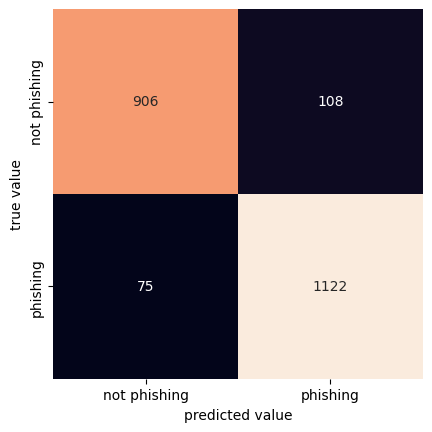

In [67]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# TO DO: Calculate confusion matrix (2 marks) : conf_mat
conf_mat = confusion_matrix(y_test, y_pred)

# Below code prints confusion matrix using a heatmap
sns.heatmap(conf_mat, xticklabels=['not phishing', 'phishing'],  yticklabels=['not phishing', 'phishing'], square=True, annot=True, cbar=False, fmt='d')
plt.xlabel('predicted value')
plt.ylabel('true value')

In [68]:
# TO DO: Print classification report (2 marks)
from sklearn.metrics import classification_report

# Generate the classification report
class_report = classification_report(y_test, y_pred, target_names=['Not Phishing', 'Phishing'])

# Print the classification report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

Not Phishing       0.92      0.89      0.91      1014
    Phishing       0.91      0.94      0.92      1197

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

**1. Answer:** The dataset shows a slight imbalance, with "Phishing" samples outnumbering "Not Phishing." However, this imbalance does not appear to impact model performance significantly, as indicated by stable evaluation metrics.

**2. Answer:**  
* **Full Dataset:** The training (93%) and testing (92%) accuracies are close, suggesting a well-fit model that generalizes well to unseen data with minimal overfitting.
* **First Two Columns Dataset:** Low training (56%) and testing accuracies (55%) indicate underfitting. Using only two features, the model struggles to capture data patterns.
* **Smaller Dataset:** Training accuracy is 92%, and testing accuracy is 88%, showing a good fit. The model performs well on both training and testing data, with a slight reduction in testing accuracy likely due to the smaller dataset size.

**3. Answer:** Increasing data and relevant features improves model accuracy. The full dataset (11055 samples, all features) achieves high accuracy (0.92-0.93), while a smaller dataset (331 samples) maintains almost similar accuracy (0.92-0.88). However, using only two features, even with the full sample size, reduces accuracy significantly (0.55-0.56) due to underfitting. This highlights the importance of both data quantity and feature relevance for performance.

**4. Answer:**
* **False Positive:** Predicts "Phishing" for a safe site, leading users to avoid safe sites. This is inconvenient but not harmful.
* **False Negative:** Predicts "Not Phishing" for a malicious site, exposing users to phishing attacks and potential harm.

* **Worse:** False Negatives are worse, as they pose security risks, potentially leading to financial loss or identity theft. False Positives are inconvenient but less severe in impact.

**5. Answer:** To minimize false negatives, maximizing **Recall** is essential. Higher recall reduces the chances of misclassifying phishing sites as safe. This can be achieved by adjusting the classification threshold, prioritizing recall in model selection, or using techniques like cost-sensitive learning or oversampling the "Phishing" class.

**6. Answer:** Lower Log Loss indicates better performance and higher confidence in predictions. The **First Two Columns dataset** has the highest Log Loss (0.69) due to underfitting from limited features. The **Full dataset** has the lowest Log Loss (0.20), indicating the best performance. The **Smaller dataset** shows a moderate Log Loss (0.29), reflecting good performance with minimal overfitting. These differences stem primarily from variations in feature selection and data size.